# Расчётно-графическая работа

## Цель работы

Научиться визуализировать полученные результаты обучения моделей с помощью
библиотеки языка Python - streamlit, а также сохранять результаты обучения
моделей с помощью встроенной библиотеки pickle и библиотеки для работы с json.

## Подключение необходимых библиотек

In [32]:
# Python 3.8
# Библиотеки для сериализации и десериализации:
import json
import pickle

# Библиотеки для обучения
import tensorflow as tf
import pandas as pd
import numpy  as np

from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

In [2]:
from IPython.display import clear_output

In [4]:
print("Число доступных устройств GPU: ", len(tf.config.list_physical_devices('GPU')))

Число доступных устройств GPU:  0


## Объявление функций

Для повышения повторяемости кода и повышения уровня читаемости объявим несколько функций с уже знакомыми операциями

In [5]:
def PLOT34(y_test, y_pred):
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменный
    :param y_pred: - вычисленные значения целевой переменный
    '''
    plt.figure(figsize=(12,6))
    
    # == Диаграмма рассеяния вычисленных значений ==
    # создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс текущего полотна в сетке
    plt.subplot(121)
    plt.scatter(y_test, y_pred,  alpha=0.1)
    plt.scatter(y_test, y_test,  alpha=0.1)
    plt.title('Диаграмма рассеяния вычисленных значений');
    plt.xlabel('Проверочное Y')
    plt.ylabel('Вычисленное Y')

    
    # == Диаграмма рассеяния ошибок ==
    # создать первое полотно 121: 1-строк, 2-столбцов, 2-индекс текущего полотна в сетке
    plt.subplot(122)
    plt.scatter(y_test, (y_test - y_pred)**2,  alpha=0.1)
    plt.title('Диаграмма рассеяния квадрата абсолютной ошибки')
    plt.xlabel('Проверочное Y')
    plt.ylabel('Квадрат абсолютной ошибки')
#--------------------------------------------------------------------------

In [6]:
def GET_METRICS_SINGLE(y_test, y_pred):
    '''
    Вычисление и вывод метрик: MAE, RMSE, R2.
    На основе сравнения проверочных и вычисленных.
    :param y_test: - проверочные значения целевой переменный
    :param y_pred: - вычисленные значения целевой переменный
    '''
    mae  = metrics.mean_absolute_error(y_test, y_pred)
    mse  = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = metrics.r2_score(y_test, y_pred)

    return (mae, mse, rmse, r2)
#--------------------------------------------------------------------------

In [7]:
def PRINT_METRICS(metrics):
    '''
    Печатает метрики, вычисленные функцией 'GET_METRICS_SINGLE'
    '''
    mae, mse, rmse, r2 = metrics

    print ("MAE : {:>9,.3f} (средняя абсолютная ошибка)".format( mae ))
    print ("MSE : {:>9,.6f} (среднеквадратичная ошибка)".format( mse ))
    print ("RMSE: {:>9,.6f} (кв. корень из среднеквадратичной ошибки)".format( rmse ))
    print ("R2  : {:>9,.3f} (коэфф. детерминации)".format( r2 ))
#--------------------------------------------------------------------------

## Загрузка подготовленных данных

In [8]:
df = pd.read_csv('../datasets/ccpp_nan_PREPARED.csv', # путь к файлу
                   sep=';',     # разделитель данных в файле
                   header=0,    # номер строки с заголовками
)
print("Размер таблицы", df.shape)
df[:2]

Размер таблицы (9376, 5)


,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75


In [9]:
features = ['AT', 'V', 'AP',  'RH']
target   = ['PE']

# Приведение к новой единой шкале. Нормализация

## Выделение X и Y

Для выполнения следующих шагов разделим исходую таблицу на две отдельных
  - dfX содержащую только объясняющие признаки
  - dfY содержащую только целевой объясняемый признак

In [10]:
dfX = df[features]
print("Размер таблицы", dfX.shape)
dfX[:2]

Размер таблицы (9376, 4)


,AT,V,AP,RH
0,8.34,40.77,1010.84,90.01
1,23.64,58.49,1011.40,74.20


In [11]:
dfY = df[target]
print("Размер таблицы", dfY.shape)
dfY[:2]

Размер таблицы (9376, 1)


,PE
0,480.48
1,445.75


## Использование класса MinMaxScaler

В библиотеке sklearn, для выполнения процедуры нормализации, присутствует более удобный класс __sklearn.preprocessing.MinMaxScaler__, который содержит методы:

- __MinMaxScaler.fit(  df  )__ - вычисление значений __минимального__, __максимального значений__ и __диапазонна__ 

- __MinMaxScaler.transform( df )__ - прямого преобразования из истинного значения к приведенному

- __MinMaxScaler.inverse_transform( df )__ - обратного преобразования из приведенного значения в истинное

Нормируем объясняющие признаки:

In [12]:
scalerNormX = MinMaxScaler() # Нормируем от 0 до 1
scalerNormX.fit(dfX)

dfXNorm = pd.DataFrame (
    data    = scalerNormX.transform(dfX), # значения ячеек    <<--
    columns = dfX.columns,  # названия столбцов
    index   = dfX.index     # идентификаторы строк
)

print("Размер таблицы", dfXNorm.shape)
dfXNorm[:2]

Размер таблицы (9376, 4)


,AT,V,AP,RH
0,0.184986,0.274199,0.443679,0.854104
1,0.618414,0.589502,0.460455,0.626851


Нормируем целевой признак:

In [13]:
scalerNormY = MinMaxScaler() # Нормируем от 0 до 1
scalerNormY.fit(dfY)

dfYNorm = pd.DataFrame (
    data    = scalerNormY.transform(dfY), # значения ячеек    <<--
    columns = dfY.columns,  # названия столбцов
    index   = dfY.index     # идентификаторы строк
)

print("Размер таблицы", dfYNorm.shape)
dfYNorm[:2]

Размер таблицы (9376, 1)


,PE
0,0.801971
1,0.339459


# Формирование тренировочной и проверочной выборок

In [14]:
valid_size  = 0.3   # доля тестовой части в выборке
rand_seed   = 42    # начальное состояние генератора случ. чисел

## Нормализованые и ненормализованные данные

Не нормализованные данные:

In [15]:
x_train, x_test, y_train, y_test =  train_test_split(
    dfX[features], # исходные данные X
    dfY[target],   # исходные данные y
    
    test_size    = valid_size, # доля тестовой части в выборке
    random_state =rand_seed,   # начальное состояние генератора случ. чисел
    shuffle=True               # перемешивание
) 

Нормализованные данные:

In [16]:
xNorm_train, xNorm_test, yNorm_train, yNorm_test =  train_test_split(
    dfXNorm[features], # исходные данные X
    dfYNorm[target],   # исходные данные y
    
    test_size    = valid_size, # доля тестовой части в выборке
    random_state =rand_seed,   # начальное состояние генератора случ. чисел
    shuffle=True               # перемешивание
) 

In [17]:
x_train[:2]

,AT,V,AP,RH
5523,20.54,68.12,1012.23,81.06
9338,29.75,73.50,1011.13,67.31


In [18]:
xNorm_train[:2]

,AT,V,AP,RH
5523,0.530595,0.760854,0.485321,0.725456
9338,0.791501,0.856584,0.452367,0.527814


In [19]:
y_train[:2]

,PE
5523,440.28
9338,433.63


In [20]:
yNorm_train[:2]

,PE
5523,0.266613
9338,0.178053


## Обучение многомерной линейной модели

In [21]:
lr = linear_model.LinearRegression()

# Вычисляем коэффициенты модели на тренировочном наборе, т.е. обучаем модель на этом наборе данных
model_lin = lr.fit(
   x_train[features], 
   y_train[target]
)

# Получаем вычисленные(predicted) значения выходной энергии электростанции на проверочном наборе
# по построенной и обученной модели
y_pred  = model_lin.predict(x_test[features])

MAE :     3.634 (средняя абсолютная ошибка)
MSE : 20.356393 (среднеквадратичная ошибка)
RMSE:  4.511806 (кв. корень из среднеквадратичной ошибки)
R2  :     0.930 (коэфф. детерминации)


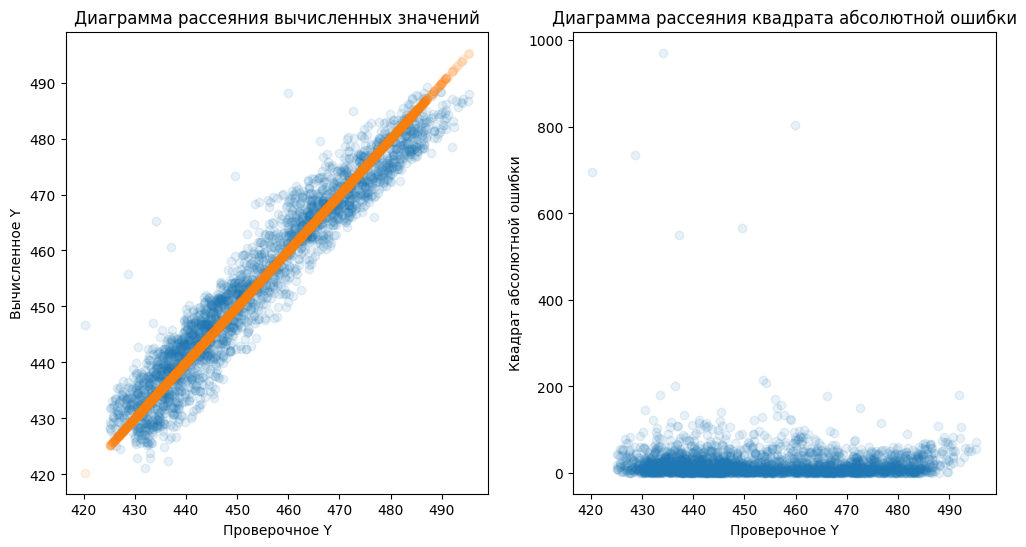

In [22]:
# Выводим метрики, а также диаграммы рассеяния
PRINT_METRICS(GET_METRICS_SINGLE(y_test, y_pred))
PLOT34(y_test, y_pred)

# Нейронная сеть со скрытыми слоями вида: 4->10->10->1

## Структура и параметры

Строим нейронную сеть:

In [23]:
with tf.device('/CPU:0'):
    
    totalHistoryLossTrain=[] # Вспомогательный список для хранение полной истории обучения
    totalHistoryLossTest=[]  # Вспомогательный список для хранение полной истории обучения
    
    ###########################################
    #▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼
    # 1) Параметры структуры
    input_size  = 4  # кол-во входных  узлов
    output_size = 1  # кол-во выходных узлов
    hiddenLayer1_size = 10  # кол-во узлов первого внутреннего слоя
    hiddenLayer2_size = 10  # кол-во узлов второго внутреннего слоя

    # 2.1) Построение модели нейронной сети
    # Многослойная    
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Input(shape=(input_size))) # Входной слой
    model.add(tf.keras.layers.Dense(
            units=hiddenLayer1_size, # Кол-во узлов/нейронов на данном слое
            activation=tf.keras.activations.tanh # Вид функции активации
        )
    ) # Первый промежуточный слой с гиперболической тангенцальной функцией активации
    model.add(tf.keras.layers.Dense(
            units=hiddenLayer2_size, # Кол-во узлов/нейронов на данном слое
            activation=tf.keras.activations.sigmoid # Вид функции активации
        )
    ) # Второй промежуточный слой с сигмоидной функцией активации
    model.add(tf.keras.layers.Dense(
            units=output_size, # Кол-во узлов/нейронов на данном слое
            activation=tf.keras.activations.linear # Вид функции активации
        )
    ) # Выходной слой, с линейной функцией активации
    
    # 2.2) Функция потерь и оптимизации:
    fLoss       = tf.keras.losses.mean_squared_error
    fOptimizer  = tf.keras.optimizers.Adam(learning_rate=0.01)
    fMetric     = [tf.keras.losses.mean_squared_error]
    
    model.compile(
        loss      = fLoss, 
        optimizer = fOptimizer, 
        metrics   = [fMetric]
    )   
    
    print(model.summary())
    #▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲
    ###########################################

2022-12-08 20:17:34.596506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
None


## Первичное и дополнительное обучение 

Обучаем сеть на 100 эпохах:

In [24]:
epochForTrain = 100

with tf.device('/CPU:0'):
    # 3) Цикл обучения/продолжения обучения сети             
    # xNorm_train, xNorm_test, yNorm_train, yNorm_test 
    history = model.fit(

        xNorm_train,  # обучающие X
        yNorm_train,  # обучающие Y

        validation_data = (  # опционально: проверочные X и Y
            xNorm_test,
            yNorm_test
        ), 

        epochs = epochForTrain, # кол-во эпох обучения
        verbose=1
    )
    
    totalHistoryLossTrain.extend(history.history['loss'])
    if 'val_loss' in history.history.keys():
        totalHistoryLossTest.extend(history.history['val_loss'])

Epoch 1/100
206/206 [==============================] - 3s 7ms/step - loss: 0.0916 - mean_squared_error: 0.0916 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 2/100
206/206 [==============================] - 1s 5ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 3/100
206/206 [==============================] - 1s 6ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/100
206/206 [==============================] - 1s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 5/100
206/206 [==============================] - 1s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 6/100
206/206 [==============================] - 1s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 7/100
206/206 [=

In [25]:
history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

## Оценка точности

Text(0.5, 0, 'Эпохи обучения')

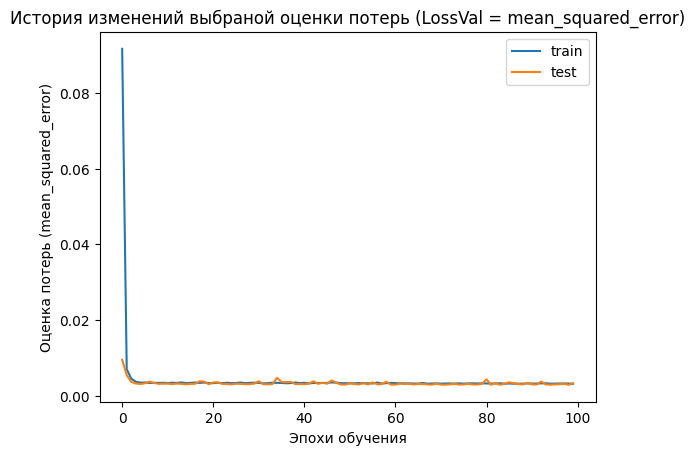

In [26]:
plt.plot(totalHistoryLossTrain, label='train')
if 'val_loss' in history.history.keys():
    plt.plot(totalHistoryLossTest, label='test')
plt.legend()
plt.title("История изменений выбраной оценки потерь (LossVal = mean_squared_error)")
plt.ylabel("Оценка потерь (mean_squared_error)")
plt.xlabel("Эпохи обучения")

88/88 [==============================] - 0s 2ms/step
MAE :     0.046 (средняя абсолютная ошибка)
MSE :  0.003412 (среднеквадратичная ошибка)
RMSE:  0.058410 (кв. корень из среднеквадратичной ошибки)
R2  :     0.934 (коэфф. детерминации)


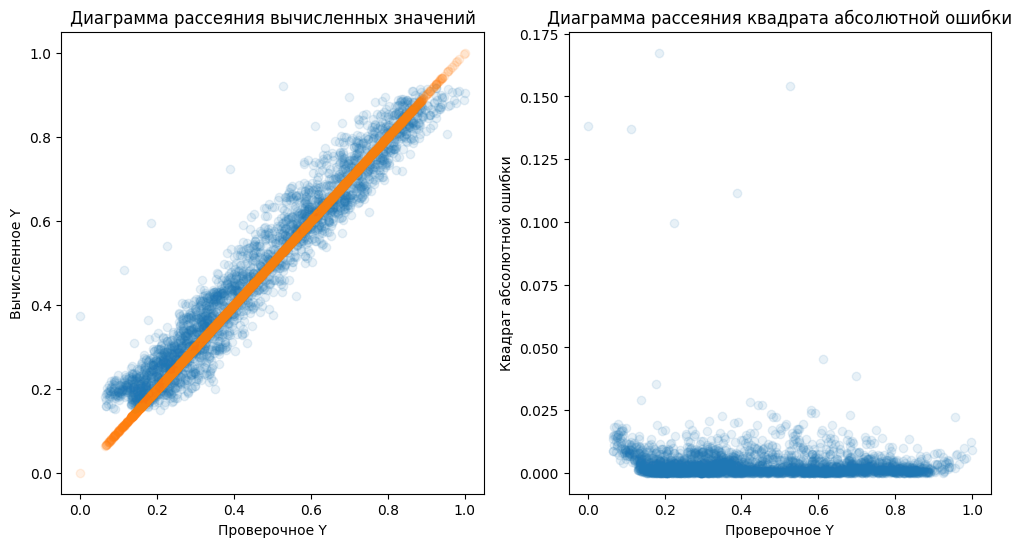

In [27]:
# Создание модели:
with tf.device('/CPU:0'):
    # Вычисление предсказанных значений:
    yNorm_pred = model.predict(xNorm_test)

_metrics = GET_METRICS_SINGLE(yNorm_test, yNorm_pred)
_, _, rmse, r2 = _metrics
PRINT_METRICS(_metrics)
PLOT34(yNorm_test, yNorm_pred)

Сохраняем в словарях информацию о исходных и о полученных результатах:

In [28]:
m1dict  = dict()
m1dict["type"] = str(type(model_lin))
m1dict["forNormalize"] = False
m1dict["forStandartize"] = False
m1dict["features"] = features
m1dict["target"] = target
m1dict["R2"]   = metrics.r2_score(y_test, y_pred)
m1dict["RMSE"]   = np.sqrt( metrics.mean_squared_error(y_test, y_pred))

m2dict  = dict()
m2dict["type"] = str(type(model))
m2dict["forNormalize"] = True
m2dict["forStandartize"] = False
m2dict["features"] = features
m2dict["target"] = target
m2dict["R2"]   = metrics.r2_score(scalerNormY.inverse_transform(yNorm_test), scalerNormY.inverse_transform(yNorm_pred))
m2dict["RMSE"]   = np.sqrt( metrics.mean_squared_error(scalerNormY.inverse_transform(yNorm_test), scalerNormY.inverse_transform(yNorm_pred)))

Серелизуем эти данные в формат JSON и сохраняем в отдельные файлы для моделей:

In [29]:
# Сохраняем данные о модели на основе линейной регрессии:
with open(r'm1.json', mode='w') as filestream:
    json.dump(m1dict, filestream,  indent=2)

# Сохраняем данные о модели на основе нейронной сети:
with open(r'm2.json', mode='w') as filestream:
    json.dump(m2dict, filestream,  indent=2)

Серелизуем и сохраняем Python-объекты моделей:

In [31]:
# Дампим нормированные данные:
with open(r'pickleScaler.bin', mode='wb') as filestream:
    pickle.dump((scalerNormX, scalerNormY), filestream)

# Дампим линейную модель:
with open(r'pickleLin.bin', mode='wb') as filestream:
    pickle.dump(model_lin, filestream)

# Дампим нейросеть:
model.save(r'tf.h5', overwrite=True, save_format="h5")